In [1]:
# Change the number of cores in this code block
# by setting `spark.master` to `local[n]` where
# n is the number of cores
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

import matplotlib.pyplot as plt

conf = pyspark.SparkConf().setAll([('spark.master', 'local[4]'),
                                   ('spark.app.name', 'Data Prep')])
spark = SparkSession.builder.config(conf=conf).getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2022-05-17 21:52:45,919 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
2022-05-17 21:52:46,599 WARN util.Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


## Read in data  
TODO: Read in cleaned movies

In [2]:
ratings_df = spark.read.csv("file:///home/work/data/ratings.csv", inferSchema=True, header=True)
ratings_df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)



In [3]:
movies_df = spark.read.csv("file:///home/work/data/movies.csv", inferSchema=True, header=True)
movies_df.printSchema()
print(f"Total distinct movies: {movies_df.count()}")

root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)

Total distinct movies: 62423


## Drop movies  
Currently only drops movies without genres

In [4]:
movies_df.createOrReplaceTempView("m")
ratings_df.createOrReplaceTempView("r")
no_genre_ratings = spark.sql("SELECT m.movieId FROM m RIGHT JOIN r ON m.movieId == r.movieId WHERE m.genres like '%no genres listed%' ")

In [5]:
tot_r = ratings_df.count()
tot_no_g = no_genre_ratings.count()
percent_lost = 100 - (((tot_r - tot_no_g) / tot_r) * 100)
print(f"Total Reviews: {tot_r} Total movies without genres: {tot_no_g} Total movies after dropping: {tot_r - tot_no_g}")
print(f"If drop ratings for movies without genres, we will lose {percent_lost:.3f}% of ratings data.")

Total Reviews: 25000095 Total movies without genres: 26627 Total movies after dropping: 24973468
If drop ratings for movies without genres, we will lose 0.107% of ratings data.


In [6]:
no_genre_ratings.createOrReplaceTempView("ng")
ratings_df = spark.sql("SELECT * FROM r LEFT ANTI JOIN ng ON r.movieId == ng.movieId")
tot_r = ratings_df.count()

## Timestamps

In [7]:
ratings_df = ratings_df.withColumn('date',from_unixtime(col("timestamp"))).withColumn('year',year("date"))
spark.sql("drop view r");
ratings_df.createOrReplaceTempView("r")

In [8]:
ratings_df.show()

+------+-------+------+----------+-------------------+----+
|userId|movieId|rating| timestamp|               date|year|
+------+-------+------+----------+-------------------+----+
|     1|   1088|   4.0|1147868495|2006-05-17 12:21:35|2006|
|     2|   1580|   4.5|1141417059|2006-03-03 20:17:39|2006|
|     2|   3175|   3.5|1141417288|2006-03-03 20:21:28|2006|
|     3|  44022|   4.0|1439473713|2015-08-13 13:48:33|2015|
|     3| 175197|   3.5|1566089493|2019-08-18 00:51:33|2019|
|     4|   1580|   4.5|1573938142|2019-11-16 21:02:22|2019|
|     4|   3175|   4.0|1573943913|2019-11-16 22:38:33|2019|
|     8|   1580|   5.0| 890510873|1998-03-21 20:07:53|1998|
|     8|   1645|   4.0| 890510977|1998-03-21 20:09:37|1998|
|     9|   1088|   5.0| 859384754|1997-03-26 13:59:14|1997|
|    12|    471|   4.0|1167582388|2006-12-31 16:26:28|2006|
|    12|   1088|   4.0|1167582465|2006-12-31 16:27:45|2006|
|    12|   1580|   3.5|1167582669|2006-12-31 16:31:09|2006|
|    12|   3794|   2.0|1137230098|2006-0

### Plot year distribution

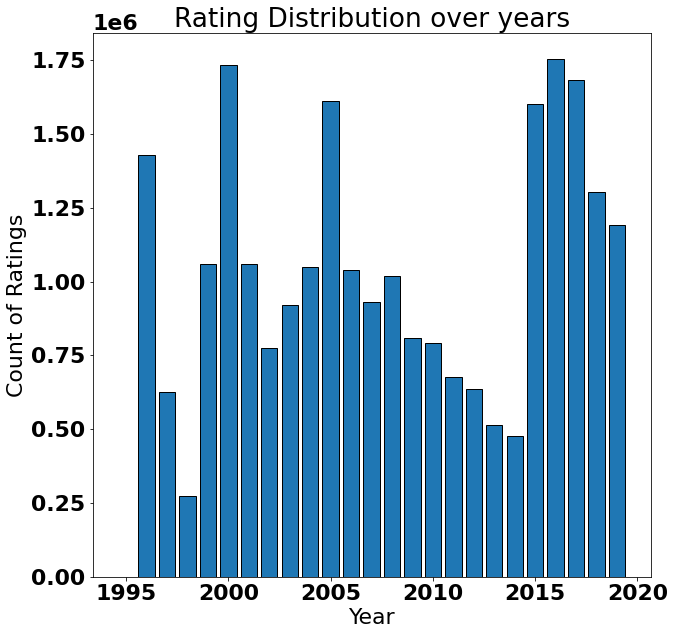

In [9]:
ratings_pd = ratings_df.groupBy("year").count().sort('count').toPandas()

font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

plt.figure(figsize=(10,10))
plt.bar(ratings_pd["year"], ratings_pd["count"],edgecolor='k')
plt.title("Rating Distribution over years")
plt.ylabel("Count of Ratings")
plt.xlabel("Year")
ax = plt.gca()
#plt.savefig('../data/rating_dist.png')

## Ratings relative to first review
ie: how many users left reviews within 1 year, 2 years, 3, ...

In [10]:
#TODO
min_ts_df = spark.sql("SELECT r.userId, MIN(r.timestamp) as min_ts FROM r GROUP BY r.userId ORDER BY r.userId ASC")
min_ts_df.createOrReplaceTempView("min_ts")
min_ts_df.show()

+------+----------+
|userId|    min_ts|
+------+----------+
|     1|1147868053|
|     2|1141415509|
|     3|1439472199|
|     4|1573937091|
|     5| 830786155|
|     6| 945141530|
|     7| 835444730|
|     8| 890489203|
|     9| 859381992|
|    10|1227570828|
|    11|1208038679|
|    12| 940765824|
|    13|1237969539|
|    14|1506208807|
|    15| 946011308|
|    16|1432077522|
|    17|1485581429|
|    18|1108271088|
|    19|1445258693|
|    20|1061997999|
+------+----------+
only showing top 20 rows



In [11]:
diff_df = spark.sql("SELECT r.userId, r.movieId, (r.timestamp - min_ts.min_ts) as time_diff  FROM r JOIN min_ts ON r.userId == min_ts.userId ORDER BY r.userId ASC")
diff_df = diff_df.withColumn('time_diff_years', round((col("time_diff") / (3600 * 24 * 365))))
diff_df.show()

+------+-------+---------+---------------+
|userId|movieId|time_diff|time_diff_years|
+------+-------+---------+---------------+
|     1|   4325|    10069|            0.0|
|     1|   6954|     1097|            0.0|
|     1|   4973|     1027|            0.0|
|     1|   1260|     9804|            0.0|
|     1|   8786|     9800|            0.0|
|     1|    665|    10767|            0.0|
|     1|   7323|     1066|            0.0|
|     1|  27266|    11312|            0.0|
|     1|   1175|      773|            0.0|
|     1|   7940|     9914|            0.0|
|     1|   2692|     1047|            0.0|
|     1|   7938|    10010|            0.0|
|     1|  32591|    11485|            0.0|
|     1|   7234|      816|            0.0|
|     1|   7361|    12002|            0.0|
|     1|   1088|      442|            0.0|
|     1|   6711|      569|            0.0|
|     1|    296|    11991|            0.0|
|     1|   1653|       44|            0.0|
|     1|   4144|      845|            0.0|
+------+---

In [12]:
diff_pd = diff_df.groupBy("time_diff_years").count().sort('count').toPandas()
diff_pd = diff_pd.rename(columns={"time_diff_years": "years"})
diff_pd = diff_pd.reset_index(drop=True)
diff_pd.sort_values(by=['count'], ascending=False)

,years,count
22,0.0,20567695
21,1.0,1491167
20,2.0,801820
19,3.0,555492
18,4.0,398841
17,5.0,262989
16,6.0,201987
15,7.0,150761
14,8.0,119056
13,9.0,90617


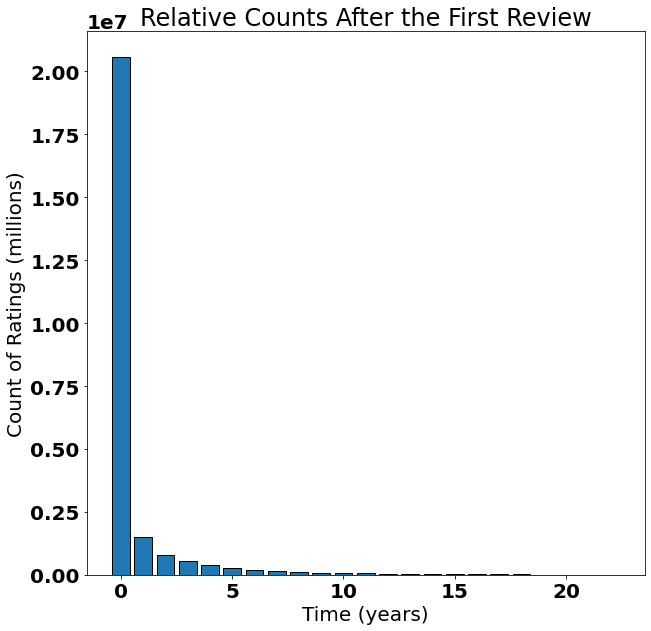

In [13]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 20}

plt.rc('font', **font)

plt.figure(figsize=(10,10))
plt.bar(diff_pd["years"], diff_pd["count"],edgecolor='k')
plt.title("Relative Counts After the First Review")
plt.ylabel("Count of Ratings (millions)")
plt.xlabel("Time (years)")
ax = plt.gca()

In [ ]:
#spark.stop()